<a href="https://www.kaggle.com/code/giuliobenedetti/learning-about-ad?scriptVersionId=158701798" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In this notebook, we aim to predict the Clinical Dementia Rating (CDR) of individuals with Alzheimer's Disease (AD) in a cross-sectional and longitudinal study design with a Machine Learning (ML) and Neural Network (NN) approach. For this purpose, we analysed two datasets belonging to the [Open Access Series of Imaging Studies](https://www.oasis-brains.org/) (OASIS):

- OASIS-I, a cross-sectional dataset with 416 subjects (Marcus et al., 2007)
- OASIS-II, a longitudinal dataset with 150 subjects (Marcus et al., 2010)

The two datasets are stored in Kaggle as [MRI and Alzheimers](https://www.kaggle.com/datasets/jboysen/mri-and-alzheimers) and can be imported as follows along with a few analytical modules.

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

df_cross = pd.read_csv("/kaggle/input/mri-and-alzheimers/oasis_cross-sectional.csv")
df_long = pd.read_csv("/kaggle/input/mri-and-alzheimers/oasis_longitudinal.csv")

# Preliminary Exploration

In this first section, we clean the data and visually explore its patterns. 

## Data Cleaning

In [2]:
# Rename cols to match names in df_cross
df_long = df_long.rename(columns={"MRI ID": "ID", "EDUC": "Educ", "MR Delay": "Delay"})

# Create columns for easy distinction between the cohorts
df_cross["Cohort"] = "OASIS1"
df_long["Cohort"] = "OASIS2"

# Concatenate df_cross with df_long
df = pd.concat([df_cross, df_long])

# Drop rows with missing target variable
df.dropna(subset=["CDR"], inplace=True)

# Remove cols with only one distinct value
df.drop(["Hand"], axis=1, inplace=True)

# Use ID as row index
df.index = df.pop("ID")

The target variable (CDR) is conventionally categorised into five levels, of which only the first four are available in our data:

| Condition            | CDR |
|----------------------|:---:|
| Healthy              | 0   |
| Very mildly demented | 0.5 |
| Mildly demented      | 1   |
| Moderately demented  | 2   |
| Severely demented    | 3   |

However, we binarise the target variable (CDR) as healthy vs demented, reducing the problem to a binary classification task. This simplifies model design as well as the assessment of its performance and partially solves the issue of class imbalance.

In [3]:
# Binarise target variable
df["CDR"] = df["CDR"].map({0: 0, 0.5: 1, 1: 1, 2: 1, 3: 1})

# Split preprocessed datasets
df_cross = df.loc[df["Cohort"] == "OASIS1", ]
df_long = df.loc[df["Cohort"] == "OASIS2", ]

## Visualisation

With respect to cross-sectional dataset.

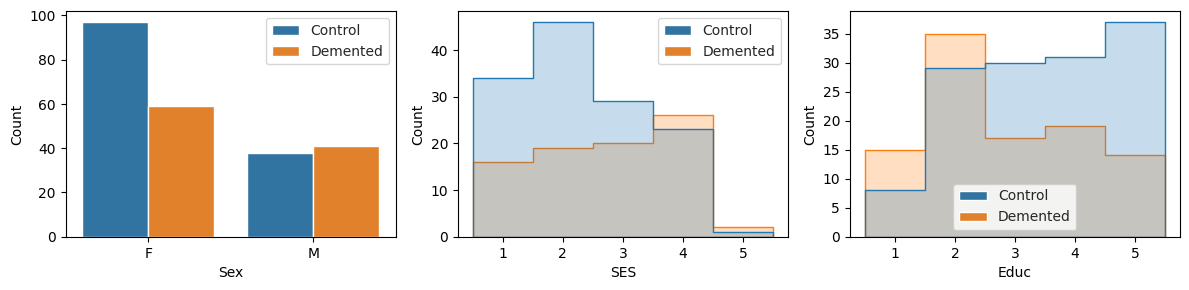

In [4]:
from matplotlib import pyplot as plt
import seaborn as sns

ncol = 3
fig, axes = plt.subplots(1, ncol)

fig.set_figheight(3)
fig.set_figwidth(12)
sns.set_style("ticks")

sns.countplot(df_cross, x="M/F", hue="CDR", ax=axes[0])
axes[0].set_xlabel("Sex")
axes[0].set_ylabel("Count")


sns.histplot(df_cross, x="SES", hue="CDR", element="step", bins=5, discrete=True, ax=axes[1])
axes[1].set_xticks(range(1, 6))

sns.histplot(df_cross, x="Educ", hue="CDR", element="step", bins=5, discrete=True, ax=axes[2])
axes[2].set_xticks(range(1, 6))

handles, _ = axes[0].get_legend_handles_labels()
labels = dict(zip(["Control", "Demented"], handles))
axes[0].legend(labels.values(), labels.keys())
axes[1].legend(labels.values(), labels.keys())
axes[2].legend(labels.values(), labels.keys(), loc='lower center')

plt.tight_layout()

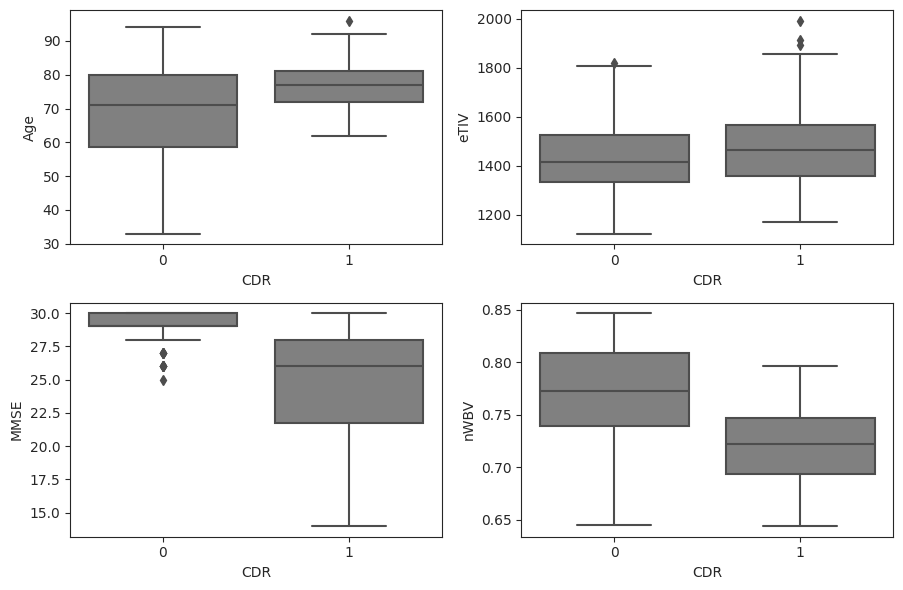

In [5]:
fig, axes = plt.subplots(2, 2)

fig.set_figheight(6)
fig.set_figwidth(9)
sns.set_style("ticks")

sns.boxplot(df_cross, x="CDR", y="Age", color="gray", ax=axes[0, 0])
sns.boxplot(df_cross, x="CDR", y="MMSE", color="gray", ax=axes[1, 0])
sns.boxplot(df_cross, x="CDR", y="eTIV", color="gray", ax=axes[0, 1])
sns.boxplot(df_cross, x="CDR", y="nWBV", color="gray", ax=axes[1, 1])

plt.tight_layout()

With respect to longitudinal dataset.

In [6]:
grouped_df = df_long.groupby(["Visit", "CDR"]).size()
size_arr = df_long.groupby("Visit").size().values

count_df = pd.DataFrame({
    "Visit": [i[0] for i in grouped_df.index],
    "CDR": [i[1] for i in grouped_df.index],
    "Count": grouped_df.values
})

count_df["Percentage"] = count_df["Count"] / count_df["Visit"].map(lambda x: size_arr[round(x) - 1]) * 100

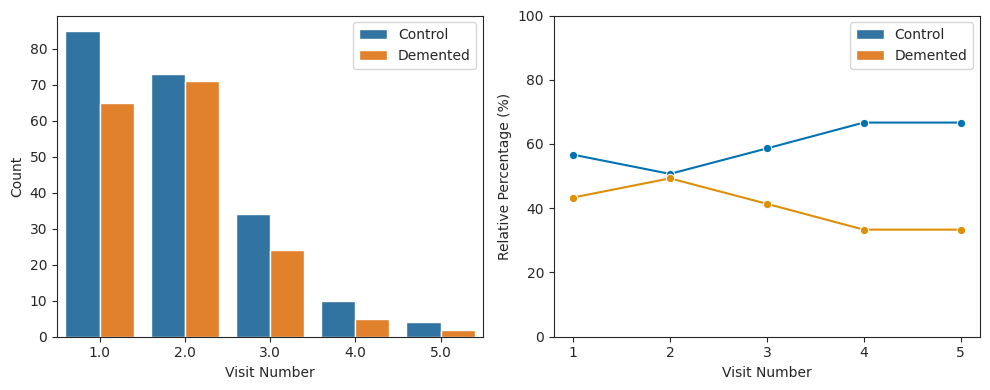

In [7]:
ncol = 2
fig, axes = plt.subplots(1, ncol)

fig.set_figheight(4)
fig.set_figwidth(10)
sns.set_style("ticks")

sns.countplot(df_long, x="Visit", hue="CDR", ax=axes[0])
axes[0].set_xlabel("Visit Number")
axes[0].set_ylabel("Count")

sns.lineplot(
    count_df, x="Visit", y="Percentage",
    hue="CDR", palette="colorblind",
    marker="o", ax=axes[1]
)

axes[1].set_xlabel("Visit Number")
axes[1].set_ylabel("Relative Percentage (%)")
axes[1].set_xticks(range(1, 6))
axes[1].set_ylim(bottom=0, top=100)

handles, _ = axes[0].get_legend_handles_labels()
labels = dict(zip(["Control", "Demented"], handles))
axes[0].legend(labels.values(), labels.keys())
axes[1].legend(labels.values(), labels.keys())

plt.tight_layout()

### Principal Component Analysis

In [8]:
from sklearn.decomposition import PCA
from scipy.stats import mode

# Label cross-sectional samples with visit 1
df["Visit"] = df["Visit"].fillna(value=1)

# Drop target, categorical variables and metadata
X = df.drop(["Delay", "Subject ID", "Group", "Visit", "M/F", "Cohort"], axis=1)
y = X.pop("CDR")

# Impute SES on the fly
X["SES"] = X["SES"].map(lambda x: mode(X["SES"])[0] if np.isnan(x) else x)
# Impute MMSE on the fly
X["MMSE"] = X["MMSE"].map(lambda x: np.nanmedian(X["MMSE"]) if np.isnan(x) else x)

# Create PCA
pca = PCA(n_components=4)
# Perform PCA
red_dims = pca.fit_transform(X)

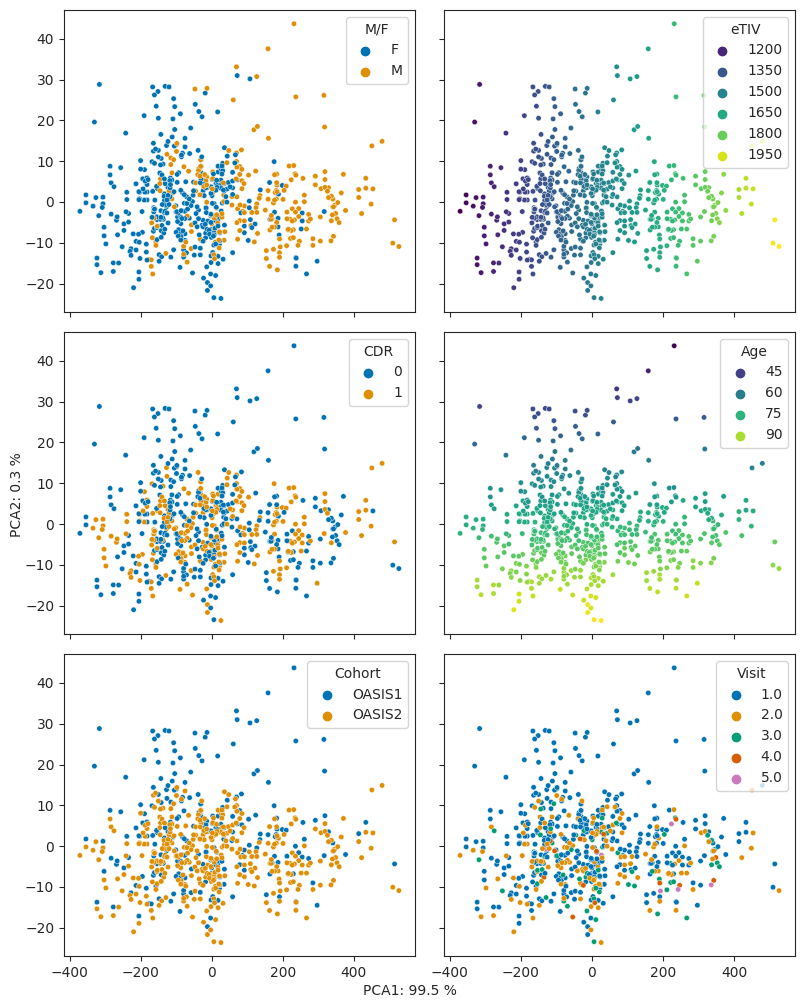

In [9]:
from utilities_for_ad import plot_pca

ncol, nrow = 3, 2
my_palette = sns.color_palette("viridis", as_cmap=True)

fig, axes = plt.subplots(ncol, nrow, sharex=True, sharey=True)

fig.set_figheight(5 * nrow)
fig.set_figwidth(8)
sns.set_style("ticks")

plot_pca(red_dims, df["M/F"], axes[0, 0])
plot_pca(red_dims, df["eTIV"], axes[0, 1], palette=my_palette)
plot_pca(red_dims, df["CDR"], axes[1, 0])
plot_pca(red_dims, df["Age"], axes[1, 1], palette=my_palette)
plot_pca(red_dims, df["Cohort"], axes[2, 0])
plot_pca(red_dims, df["Visit"], axes[2, 1])

fig.text(0.5, 0, f"PCA1: {pca.explained_variance_ratio_[0] * 100:.1f} %", ha="center")
fig.text(0, 0.5, f"PCA2: {pca.explained_variance_ratio_[1] * 100:.1f} %", va="center", rotation="vertical")

plt.tight_layout()

### Correlation Heatmap

We inspected relationships between variables in terms of correlation. Among others, nWBV appeared to be negatively correlated with age and positively correlated with MMSE, whereas eTIV and ASF were almost completely opposite to one another.

<Axes: >

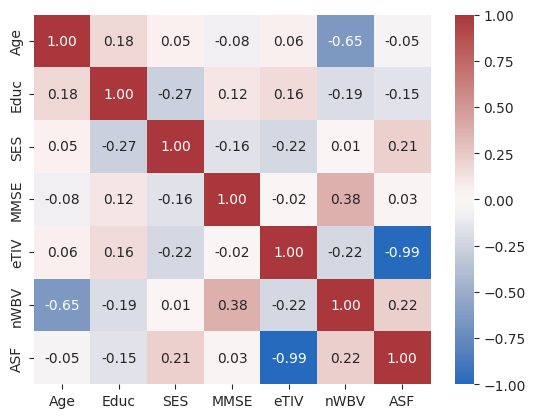

In [10]:
corr = X.corr()
sns.heatmap(
    corr, cmap="vlag", annot=True,
    fmt=".2f", annot_kws={'size': 10},
    vmin=-1, vmax=1
)

### Mutual Information

We assessed the contribution of each variable to the degree of confidence about the target variable in terms of mutual information. eTIV and MMSE turned out to be the most informative variables, whereas other MRI and demographic variables played a secondary role.


In [11]:
# Add sex back into variables
X["M/F"] = df["M/F"]
# Specify discrete variables
discrete_features = ["M/F", "SES", "Educ"]

# Factorise discrete variables
for col in discrete_features:
    X[col], _ = X[col].factorize()
    
# Convert type to integer
discrete_features = X.dtypes == int

Text(0.5, 0, 'Mutual Information')

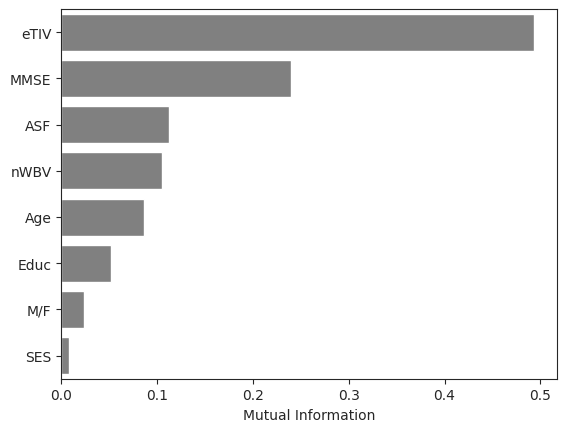

In [12]:
from sklearn.feature_selection import mutual_info_classif

# Compute mutual information scores
mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
# Convert scores into series
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
# Sort scores by magnitude
mi_scores = mi_scores.sort_values(ascending=False)

# Visualise mutual information with barplot
sns.barplot(x=mi_scores, y=mi_scores.index, color="gray")
plt.xlabel("Mutual Information")

# Cross-Sectional Analysis

(expand).

## Preprocessing

train/test split (expand).

In [13]:
from utilities_for_ad import X_y_split
from sklearn import model_selection as ms

# Split X and y for cross-sectional dataset
X_cross, y_cross = X_y_split(df_cross)

# Set fraction of data allocated to the test set 
test_fraction = 0.1

# Split train/devel set from test set
X_train, X_test, y_train, y_test = ms.train_test_split(
    X_cross, y_cross,
    test_size=test_fraction,
    stratify=y_cross,
    random_state=123,
)

Feature Imputation (expand).

In [14]:
from sklearn.impute import SimpleImputer

# Given a uniform distribution, impute SES with mode
ses_imputer = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
# Given a skewed distribution, impute MMSE with median
mmse_imputer = SimpleImputer(missing_values=np.nan, strategy="median")

# Apply SES imputer to data
X_train["SES"] = ses_imputer.fit_transform(X_train[["SES"]])
X_test["SES"] = ses_imputer.transform(X_test[["SES"]])

# Apply MMSE imputer to data
X_train["MMSE"] = mmse_imputer.fit_transform(X_train[["MMSE"]])
X_test["MMSE"] = mmse_imputer.transform(X_test[["MMSE"]])

**Data normalisation** helps standardise features and speed up learning. Thus, data is normalised by scaling numerical variables and one-hot encoding categorical ones. Ordinal variables may also need normalisation, but options for this type have not been found yet.

In [15]:
from sklearn import preprocessing
from sklearn.compose import make_column_transformer

# Categorise variables by type
categorical_vars = ["M/F"]
numerical_vars = ["Age", "eTIV", "nWBV", "MMSE"]
ordinal_vars = ["Educ", "SES"]

# Build preprocessor
preprocessor = make_column_transformer(
    (preprocessing.StandardScaler(), numerical_vars),
    (preprocessing.OneHotEncoder(), categorical_vars)
)

# Apply preprocessor to data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

We also prepare a version of the train data without MMSE for benchmarking purposes.


In [16]:
# Reconstruct feature names after transformation
feature_names = preprocessor.get_feature_names_out()

# Get index of MMSE in transformed array
mmse_index = np.where(feature_names == 'standardscaler__MMSE')[0][0]

# Create train and test set without mmse
X_train_without_mmse = np.delete(X_train, mmse_index, axis=1)
X_test_without_mmse = np.delete(X_test, mmse_index, axis=1)

## Clustering

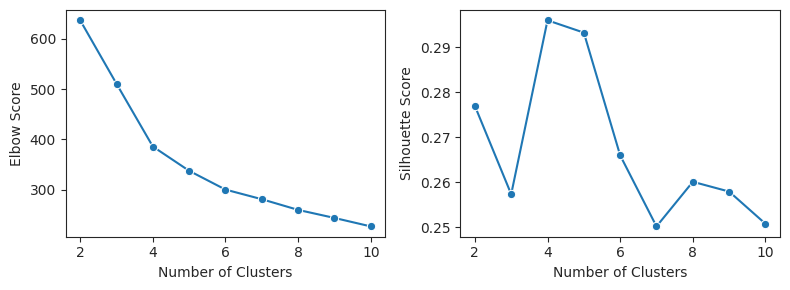

In [17]:
from utilities_for_ad import score_cluster

n_clusters = range(2, 11)
scores = np.array(list(map(lambda n_clusters: score_cluster(X_train, n_clusters), n_clusters)))
elbow, silhouette = scores[:, 0], scores[:, 1]

fig, axes = plt.subplots(1, 2)

fig.set_figheight(3)
fig.set_figwidth(8)
sns.set_style("ticks")

sns.lineplot(x=n_clusters, y=elbow, marker="o", ax=axes[0])
axes[0].set_xlabel("Number of Clusters")
axes[0].set_ylabel("Elbow Score")

sns.lineplot(x=n_clusters, y=silhouette, marker="o", ax=axes[1])
axes[1].set_xlabel("Number of Clusters")
axes[1].set_ylabel("Silhouette Score")

plt.tight_layout()

In [18]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=123).fit(X_train)
train_clusters = kmeans.labels_.reshape(-1, 1)
test_clusters = kmeans.predict(X_test).reshape(-1, 1)

X_train = np.hstack([X_train, train_clusters])
X_test = np.hstack([X_test, test_clusters])

## Validation Performance

Currently, the criterion to select the most performant model is based on two validation metrics: accuracy and confusion matrix. The former gives a general measure of the classification power, whereas the latter provides a more detailed insight into the bias of the model. It may be useful to validate the models with other metrics which put more weight on the rare classes, that is, the demented subjects.

In [19]:
# Set k equal to the number of occurrences of least populated class
k_folds = 10

# Create stratified K-fold validator
skf = ms.StratifiedKFold(
    n_splits=k_folds,
    shuffle=True,
    random_state=123
)

_What is the minimal performance that we should expect from a model?_ This question can be answered by setting a **baseline performance**. This usually corresponds to the accuracy obtained with a very simple model, such as a classifier that predicts everything to be the most frequent class. The latter approach is applied here to estimate a baseline performance for the cross-sectional and longitudinal datasets as well as the combined dataset.

In [20]:
from utilities_for_ad import baseline_performance
from sklearn.metrics import balanced_accuracy_score

print(f"Baseline accuracy: {baseline_performance(X_cross, y_cross, metric=balanced_accuracy_score):.2f}")

Baseline accuracy: 0.50


The baseline performance remains similar among the three datasets with an average of around 56%. This is the minimum accuracy that we want to achieve with a more suitable model.

## Model Selection

The most performant model was selected from a pool of models belonging to multiple families of classifiers. The candidate models include:

- Gaussian process
- Gradient boosting
- Linear Discriminant Analysis (LDA)
- Logistic regression
- Random forest
- Support Vector Machine (SVM)


In every algorithm that allowed it, the random seed was fixed and class imbalance was taken into account. To add a new model, you can simply import it from a package, create it and store it in the dictionary of classifiers under a name of your choice.

In [21]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

seed = 123
class_weight = "balanced"

# Prepare empty dictionary to store models
models = {}

# Create Gaussian classifier
models["Gaussian Process"] = GaussianProcessClassifier(random_state=seed)
# Create XGBoost classifier
models["Gradient Boosting"] = GradientBoostingClassifier(random_state=seed)
# Create QDA classifier
models["Linear Discriminant"] = LinearDiscriminantAnalysis()
# Create logistic classifier
models["Logistic Regression"] = LogisticRegression(class_weight=class_weight)
# Create random forest classifier
models["Random Forest"] = RandomForestClassifier(random_state=seed, class_weight=class_weight)
# Create SVM classifier
models["SVM"] = SVC(random_state=seed, class_weight=class_weight)

### Add new models here ###
# models["name"] = model()

In [22]:
from utilities_for_ad import validate_model, make_confusion_matrix

# Validate models with accuracy
acc_scores = list(map(lambda model: validate_model(model, X_train, y_train, metric=balanced_accuracy_score, cv=skf).mean(), models.values()))
acc_scores = dict(zip(models.keys(), acc_scores))

# Validate models with a confusion matrix
confusion_matrices = list(map(lambda model: make_confusion_matrix(model, X_train, y_train, cv=skf), models.values()))
confusion_matrices = dict(zip(models.keys(), confusion_matrices))

Gaussian Process    : ACC = 0.810
Gradient Boosting   : ACC = 0.808
Linear Discriminant : ACC = 0.812
Logistic Regression : ACC = 0.834
Random Forest       : ACC = 0.816
SVM                 : ACC = 0.828


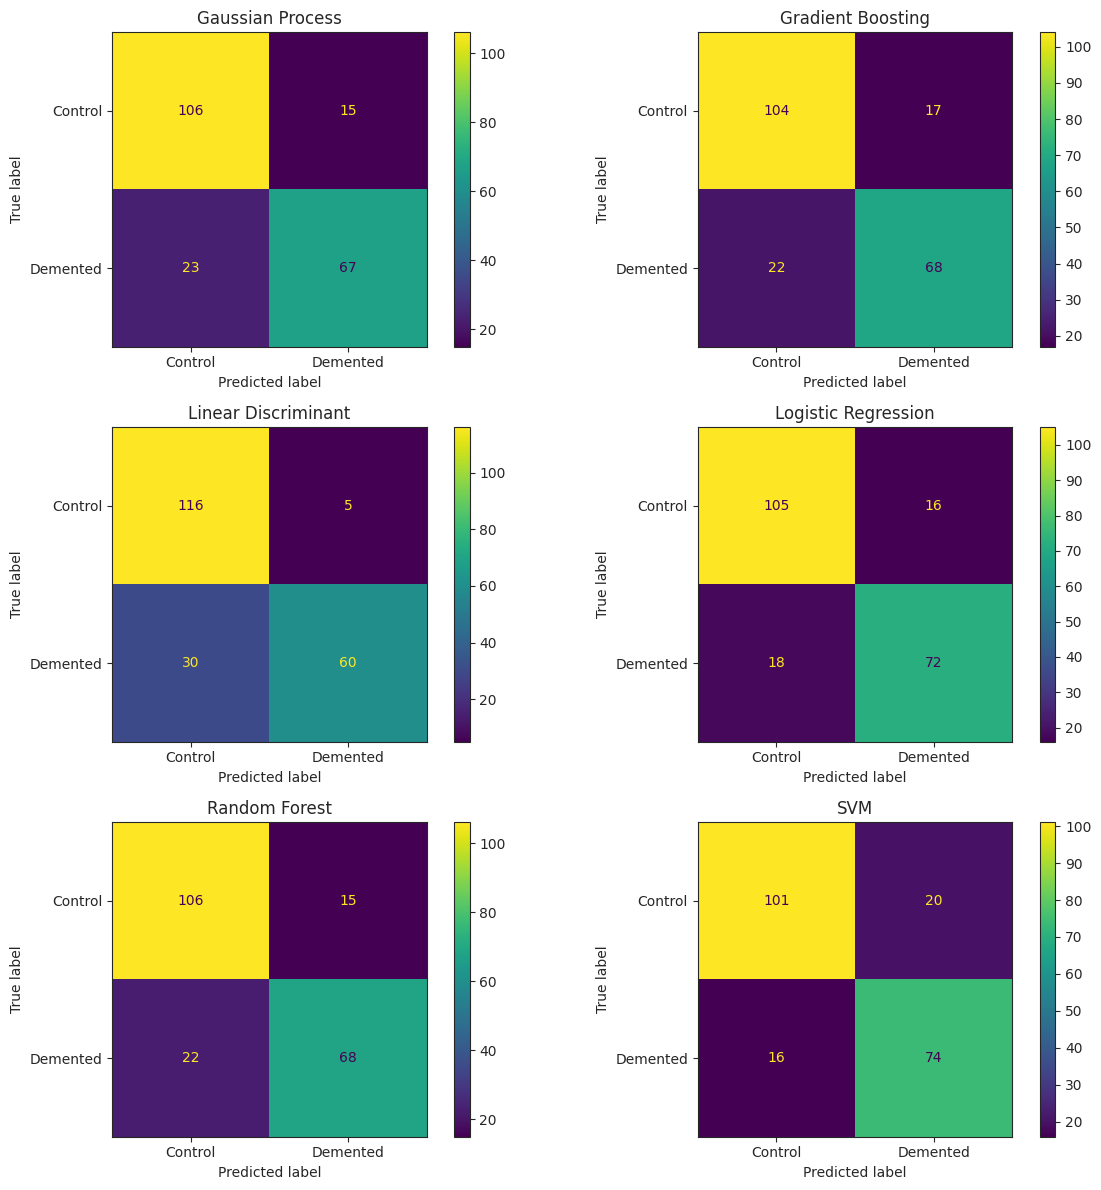

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ncol = 2
model_num = len(models)
nrow = round(np.ceil(model_num / ncol))

fig, axes = plt.subplots(nrow, ncol)

fig.set_figheight(4 * nrow)
fig.set_figwidth(6 * ncol)

# Print validation profile for each model
for idx, (name, model) in enumerate(models.items()):

    print(f"{name:20s}: ACC = {acc_scores[name].mean():.3f}")

    if idx == 0:
        row_idx = 0
    elif idx % ncol == 0:
        row_idx += 1
    
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrices[name], display_labels=["Control", "Demented"])
    disp.plot(ax=axes[row_idx, idx % ncol])
    disp.ax_.set_title(name)

plt.tight_layout()

## Hyperparameter Tuning

_How can we optimise the selected model to improve performance?_ The answer to this question lies in **hyperparameter tuning**. Here, the goal consists in finding the combination of values for the model hyperparameters in order to achieve the best possible performance. This is usually done with a grid search, which can be either full or randomised. The former searches over the full grid for the actual best combination, whereas the latter only searches over a random subset of the grid. Randomised grid search reduces the computational demand while still providing a nearly optimal combination of values, for which reason it is applied below.

In [24]:
# Select the best classifier algorithm
selected_key = max(acc_scores, key=acc_scores.get)
selected_model = models[selected_key]

# View the best classifier algorithm
selected_model

LogisticRegression(class_weight='balanced')

In [25]:
# Provide parameters to optimise and grid values
if selected_key == "Random Forest":
    
    param_grid = { 
        "n_estimators": [25, 50, 100, 150], 
        "max_features": ["sqrt", "log2", None], 
        "max_depth": [3, 6, 9], 
        "max_leaf_nodes": [3, 6, 9], 
    } 
    
elif selected_key == "SVM":
    
    param_grid = {
        "C": [1, 10, 100, 1000],
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
        "degree": [2, 3, 4, 5],
        "gamma": ["auto", "scale"]
    }

elif selected_key == "Logistic Regression":
    
    param_grid = {
        "solver": ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"],
        "penalty": ["none", "l1", "l2", "elasticnet"], 
        "C":[1, 1.2, 1.4, 1.6, 1.8, 2, 5, 10, 100, 1000]
    }   

In [26]:
from sklearn.metrics import make_scorer
from functools import reduce

# Convert parameter grid to list
grid_values = list(param_grid.values())
# Compute number of possible combinations (full grid)
full_search_iter = reduce(lambda x, y: x * len(y), grid_values[1:], len(grid_values[0]))

# Perform randomised search for best combination of parameters
tuned_models = ms.RandomizedSearchCV(
    estimator=selected_model,
    param_distributions=param_grid,
    n_iter=min(full_search_iter, 60), 
    scoring=make_scorer(balanced_accuracy_score),
    cv=skf,
    random_state=123
)

In [27]:
# Train tuned models
tuned_models.fit(X_train, y_train)

# Select the best model in terms of accuracy
tuned_model = tuned_models.best_estimator_

# View the best model
tuned_model

LogisticRegression(C=1.4, class_weight='balanced', solver='newton-cg')

## Model Assessment

After selecting and tuning the best model, it is finally time to test its performance on the test set. Getting nervous, how well will it do?

In [28]:
# Predict CDR of test set with best tuned model
tuned_model.fit(X_train, y_train)
y_pred = tuned_model.predict(X_test)

# Train best model on dataset without MMSE
tuned_model.fit(X_train_without_mmse, y_train)
y_pred_no_mmse = tuned_model.predict(X_test_without_mmse)

print("Accuracy of best tuned model")
print(f"with MMSE: {balanced_accuracy_score(y_test, y_pred):.3f}")
print(f"without MMSE: {balanced_accuracy_score(y_test, y_pred_no_mmse):.3f}")

Accuracy of best tuned model
with MMSE: 0.807
without MMSE: 0.786


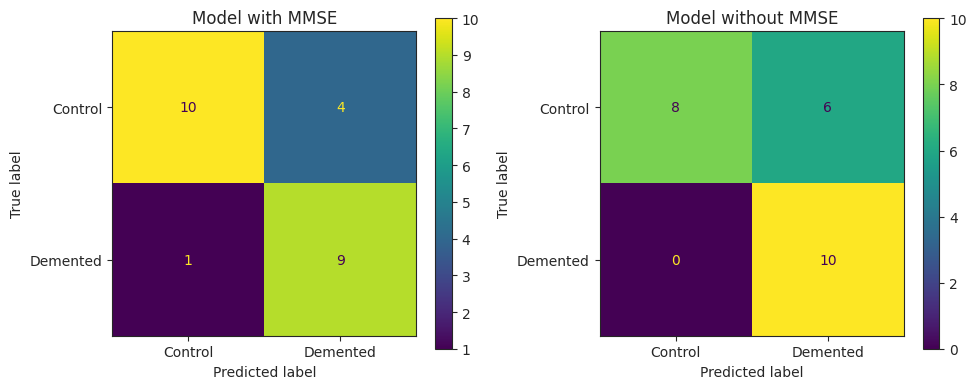

In [29]:
fig, axes = plt.subplots(1, 2)

fig.set_figheight(4)
fig.set_figwidth(10)

# Plot confusion matrix for model with MMSE
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Control", "Demented"])
disp.plot(ax=axes[0])
axes[0].set_title("Model with MMSE")

# Plot confusion matrix for model without MMSE
cm = confusion_matrix(y_test, y_pred_no_mmse)
disp = ConfusionMatrixDisplay(cm, display_labels=["Control", "Demented"])
disp.plot(ax=axes[1])
axes[1].set_title("Model without MMSE")

plt.tight_layout()

The accuracy appeared lower in the model without MMSE than in the model with MMSE. However, there were less false negatives and more false positives than before, that is, a better recall.

### Deep Learning Approach

In [30]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from utilities_for_ad import reproduce_environment

# Set input shape
input_shape = [X_train.shape[1]]

# Build model
def design_model():
    
    model = keras.Sequential([
        layers.BatchNormalization(),
        layers.Dense(4, activation="relu", input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Dropout(rate=0.3),
        layers.Dense(4, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(rate=0.3),
        layers.Dense(1, activation="sigmoid")
    ])

    return model

In [31]:
# Initialise empty lists
train_accuracies = []
devel_accuracies = []

# Perform 10-fold cross-validation
for train_index, devel_index in skf.split(X_train, y_train):
    
    # Subset train and devel sets
    train_subset = X_train[train_index]
    train_labels = y_train[train_index]
    devel_subset = X_train[devel_index]
    devel_labels = y_train[devel_index]
    
    # Make environment reproducible
    reproduce_environment(random_state=123)
    
    # Build model
    model = design_model()
    
    # Compile model
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=["binary_accuracy"]
    )
    
    # Train model
    history = model.fit(
        train_subset, train_labels,
        validation_data=(devel_subset, devel_labels),
        epochs=100,
        batch_size=20,
        verbose=False
    )
    
    # Fetch accuracy
    history_df = pd.DataFrame(history.history)
    
    train_accuracies.append(history_df['binary_accuracy'].iloc[-1])
    devel_accuracies.append(history_df['val_binary_accuracy'].iloc[-1])
    
    print(f"Train accuracy: {train_accuracies[-1]:.3f}, Devel accuracy: {devel_accuracies[-1]:.3f}")  

Train accuracy: 0.709, Devel accuracy: 0.727
Train accuracy: 0.679, Devel accuracy: 0.714
Train accuracy: 0.668, Devel accuracy: 0.762
Train accuracy: 0.663, Devel accuracy: 0.810
Train accuracy: 0.647, Devel accuracy: 0.810
Train accuracy: 0.663, Devel accuracy: 0.810
Train accuracy: 0.684, Devel accuracy: 0.714
Train accuracy: 0.689, Devel accuracy: 0.810
Train accuracy: 0.700, Devel accuracy: 0.667
Train accuracy: 0.684, Devel accuracy: 0.714


In [32]:
# Make environment reproducible
reproduce_environment(random_state=123)

# Build model
model = design_model()
    
# Compile model
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["binary_accuracy"]
)

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=20,
    verbose=False
)

history_df = pd.DataFrame(history.history)
print(f"Train accuracy: {history_df['binary_accuracy'].iloc[-1]:.3f}, Test accuracy: {history_df['val_binary_accuracy'].iloc[-1]:.3f}")

Train accuracy: 0.787, Test accuracy: 0.708


<Axes: title={'center': 'Accuracy'}>

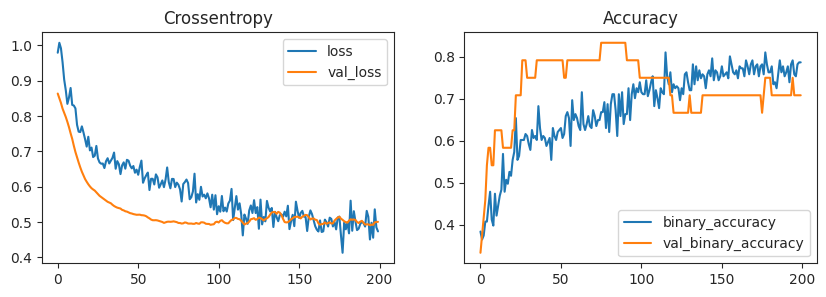

In [33]:
fig, axes = plt.subplots(1, 2)

fig.set_figheight(3)
fig.set_figwidth(10)

# Visualise loss
history_df.loc[:, ["loss", "val_loss"]].plot(title="Crossentropy", ax=axes[0])
history_df.loc[:, ["binary_accuracy", "val_binary_accuracy"]].plot(title="Accuracy", ax=axes[1])

1/1 [==============================] - 0s 153ms/step
Accuracy of neural network: 0.736


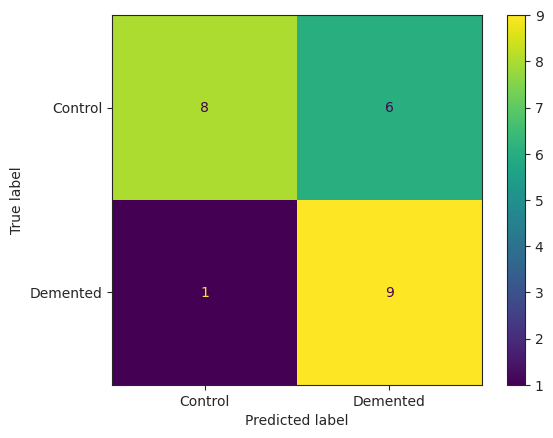

In [34]:
# Predict labels
y_pred = model.predict(X_test) >= 0.5
y_pred = y_pred.astype(int)

print(f"Accuracy of neural network: {balanced_accuracy_score(y_test, y_pred):.3f}")

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
dist = ConfusionMatrixDisplay(cm, display_labels=["Control", "Demented"])
dist.plot()

## Conclusions

In [35]:
acc_scores = list(map(lambda model: validate_model(model, X_train, y_train, metric=balanced_accuracy_score, cv=skf), models.values()))

eval_df = pd.DataFrame(acc_scores, index=models.keys())

eval_df.loc[len(eval_df)] = devel_accuracies
eval_df.rename(index={len(eval_df) - 1: "Neural Network"}, inplace=True)

eval_df["Classifier"] = eval_df.index
eval_df = pd.melt(eval_df, id_vars="Classifier", value_vars=range(k_folds))

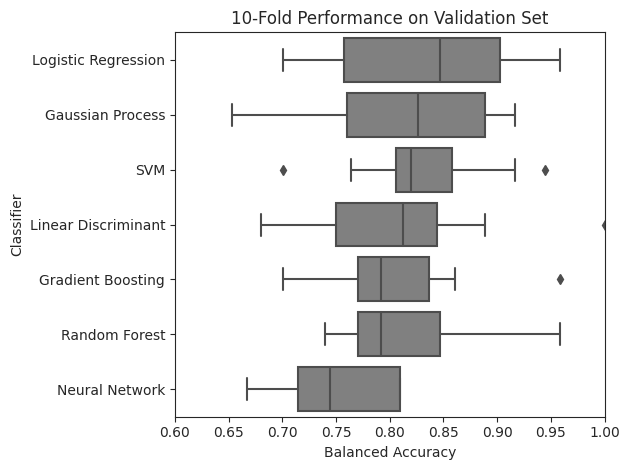

In [36]:
medians = eval_df.groupby(["Classifier"])["value"].median().sort_values(ascending=False)

sns.boxplot(eval_df, y="Classifier", x="value", color="gray", order=medians.index)

plt.title("10-Fold Performance on Validation Set")
plt.xlim([0.6, 1])
plt.xlabel("Balanced Accuracy")

plt.tight_layout()

# Longitudinal Analysis

In this part of the notebook, we implement a Long-Short Term Memory (LSTM) network to predict a patient's CDR from the data obtained in their previous visits, which results in a train accuracy of 85% and a test accuracy of 80%.

## Preprocessing

The data was preprocessed so that only sequential features are included in the samples. Because all samples need a value for each time point, missing values were forward-filled from the value of the previous visit. A few preprocessed samples can be viewed below.

In [37]:
# Convert visit variable to string
df_long["Visit"] = df_long["Visit"].astype(str)

# List sequential features
changing_vars = ["Age", "MMSE", "eTIV", "nWBV", "ASF", "CDR"]
# List constant features
stable_vars = ["M/F", "SES", "Educ"]

# Pivot dataframe along subject ID
X = df_long.pivot(
    index="Subject ID",
    columns="Visit",
    values=changing_vars
)

# Reset index and forward fill missing data
X = X.reset_index().ffill(axis=1)

# Rename columns for easy indexing
X.columns = [" ".join(col).strip(".0| ") for col in X.columns.values]
# Use subject ID as index
X.index = X.pop("Subject ID")

# Print head of dataframe
X.head()

,Age 1,Age 2,Age 3,Age 4,Age 5,MMSE 1,MMSE 2,MMSE 3,MMSE 4,MMSE 5,...,ASF 1,ASF 2,ASF 3,ASF 4,ASF 5,CDR 1,CDR 2,CDR 3,CDR 4,CDR 5
Subject ID,,,,,,,,,,,,,,,,,,,,,
OAS2_0001,87.0,88.0,88.0,88.0,88.0,27.0,30.0,30.0,30.0,30.0,...,0.883,0.876,0.876,0.876,0.876,0.0,0.0,0.0,0.0,0.0
OAS2_0002,75.0,76.0,80.0,80.0,80.0,23.0,28.0,22.0,22.0,22.0,...,1.046,1.01,1.034,1.034,1.034,1.0,1.0,1.0,1.0,1.0
OAS2_0004,88.0,90.0,90.0,90.0,90.0,28.0,27.0,27.0,27.0,27.0,...,1.444,1.462,1.462,1.462,1.462,0.0,0.0,0.0,0.0,0.0
OAS2_0005,80.0,83.0,85.0,85.0,85.0,28.0,29.0,30.0,30.0,30.0,...,1.039,1.032,1.033,1.033,1.033,0.0,1.0,0.0,0.0,0.0
OAS2_0007,71.0,71.0,73.0,75.0,75.0,28.0,28.0,27.0,27.0,27.0,...,1.293,1.293,1.286,1.279,1.279,1.0,1.0,1.0,1.0,1.0


Next, we reshape the dataset so that every element is a matrix where rows represent time points and columns represent features. The sequence containing the target variable was then separated from the matrix of features.

In [38]:
# Set the length of the time series
n_timepoints = 5

# Reshape dataframe so that every element is a matrix where
# rows represent time points and columns represent features
ds = X.to_numpy().reshape(-1, len(changing_vars), n_timepoints)
ds = np.transpose(ds, (0, 2, 1))

# Fetch features
X = ds[:, :, :-1].astype("float32")
# Fetch target variable
y = ds[:, :, n_timepoints].astype(int)

print("Sample feature sequence:")
print(X[0])
print("\n")
print("Sample target sequence:")
print(y[0])

Sample feature sequence:
[[8.700e+01 2.700e+01 1.987e+03 6.960e-01 8.830e-01]
 [8.800e+01 3.000e+01 2.004e+03 6.810e-01 8.760e-01]
 [8.800e+01 3.000e+01 2.004e+03 6.810e-01 8.760e-01]
 [8.800e+01 3.000e+01 2.004e+03 6.810e-01 8.760e-01]
 [8.800e+01 3.000e+01 2.004e+03 6.810e-01 8.760e-01]]


Sample target sequence:
[0 0 0 0 0]


The data was splitted into a train/devel and a test set. The latter was formed with 10% of samples. The number of visit varied between two and five and thus it was used for stratification.

In [39]:
# Count number of visits for each subject
visit_count = df_long.groupby("Subject ID")["Visit"].nunique().to_numpy()

# Split data into train/devel and test sets
X_train, X_test, y_train, y_test = ms.train_test_split(
    X, y,
    test_size=0.1,
    stratify=visit_count,
    random_state=123
)

# Compute mean of features in train set
train_mean = X_train.reshape(-1, 5).mean(axis=0)
# Compute standard deviation of features in train set
train_std = X_train.reshape(-1, 5).std(axis=0)

# Normalise train set
X_train = (X_train - train_mean) / train_std
# Normalise test set
X_test = (X_test - train_mean) / train_std

input_shape = X_train[0].shape

print(f"Size of train set: {len(X_train)}")
print(f"Size of test set: {len(X_test)}")
print(f"Input shape: {input_shape}")

Size of train set: 135
Size of test set: 15
Input shape: (5, 5)


## Prediction

We designed a relatively small LSTM model with two recurrent layers made of 10 units each. Such design allows to use all information from the previous timepoints predict CDR at a given timepoint.

In [40]:
# Make environment reproducible
reproduce_environment(random_state=123)

# Design LSTM model with one recurrent layer
model = keras.Sequential([
    layers.LSTM(20, return_sequences=True),
    layers.Dense(1, activation="sigmoid")
])

# Compile model
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["binary_accuracy"]
)

The model was trained until convergence was achieved, which returned a satisfactory performance of 85% train accuracy and 80% test accuracy.

In [41]:
# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=150,
    batch_size=30,
    verbose=False
)

# Store training history as a dataframe
history_df = pd.DataFrame(history.history)

print(f"Train loss: {history_df['loss'].iloc[-1]:.3f}, Test loss: {history_df['val_loss'].iloc[-1]:.3f}")
print(f"Train accuracy: {history_df['binary_accuracy'].iloc[-1]:.3f}, Test accuracy: {history_df['val_binary_accuracy'].iloc[-1]:.3f}")

Train loss: 0.362, Test loss: 0.464
Train accuracy: 0.850, Test accuracy: 0.800


From the loss curve, the model appeared to slightly overfit, for which reason more data should be used or regularisation should be implemented. The former solution is especially appropriate in our case, because the model in its current state is not fed with constant features such as sex, education and SES. Adding them to the input will likely improve the predictive performance of the model.

<Axes: title={'center': 'Accuracy'}>

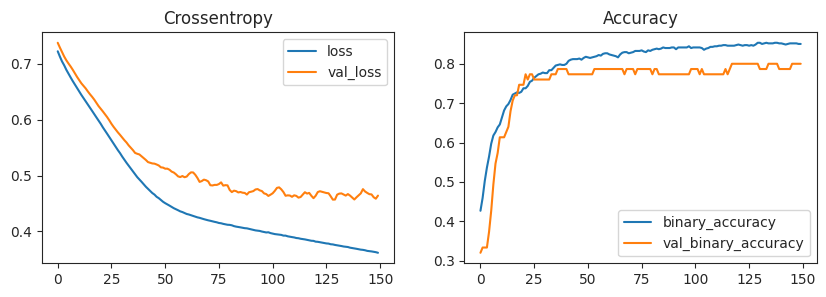

In [42]:
fig, axes = plt.subplots(1, 2)

fig.set_figheight(3)
fig.set_figwidth(10)

# Visualise performance
history_df.loc[:, ["loss", "val_loss"]].plot(title="Crossentropy", ax=axes[0])
history_df.loc[:, ["binary_accuracy", "val_binary_accuracy"]].plot(title="Accuracy", ax=axes[1])

## Results

1/1 [==============================] - 0s 456ms/step
Accuracy of neural network: 0.808


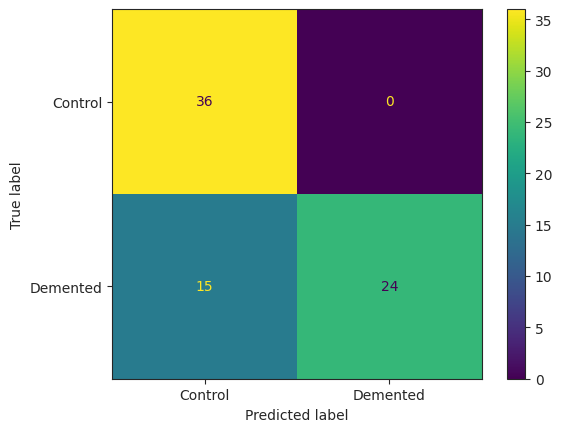

In [43]:
# Predict labels
y_pred = model.predict(X_test) >= 0.5
y_pred = y_pred.astype(int).reshape(-1, 1)

flat_y_test = y_test.reshape(-1, 1)

print(f"Accuracy of neural network: {balanced_accuracy_score(flat_y_test, y_pred):.3f}")

# Plot confusion matrix
cm = confusion_matrix(flat_y_test, y_pred)
dist = ConfusionMatrixDisplay(cm, display_labels=["Control", "Demented"])
dist.plot()

In [44]:
from numpy.matlib import repmat

# Store true and predicted labels in dataframe
test_df = pd.DataFrame(np.hstack([flat_y_test, y_pred]), columns=["true", "pred"])

# Add columns for subject, timepoint and prediction outcome
test_df["Subject"] = np.arange(1, 16).repeat(n_timepoints)
test_df["Timepoint"] = repmat(np.arange(1, 6), 1, 15).T
test_df["Diff"] = test_df["true"] - test_df["pred"]

# Rearrange prediction outcome into colour matrix
diff_mat = pd.pivot_table(test_df, values="Diff",index=["Subject"], columns=["Timepoint"])
# Rearrange true labels into annotation matrix
cdr_mat = pd.pivot_table(test_df, values="true", index=["Subject"], columns=["Timepoint"])


Text(0.5, 1.0, 'Predictions on Test Set')

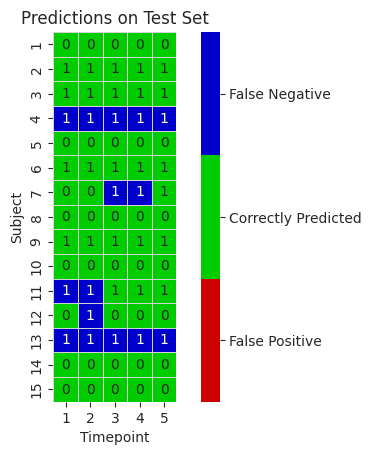

In [45]:
from matplotlib.colors import LinearSegmentedColormap

# Define custom colour map
my_colours = ((0.8, 0.0, 0.0, 1.0), (0.0, 0.8, 0.0, 1.0), (0.0, 0.0, 0.8, 1.0))
cmap = LinearSegmentedColormap.from_list('Custom', my_colours, len(my_colours))

# Plot heatmap
p = sns.heatmap(
    diff_mat, square=True,
    vmin=-1, vmax=1,
    cmap=cmap, annot=cdr_mat,
    linewidths=0.5, linecolor='lightgray')

# Specify colour bar manually
colorbar = p.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(["False Positive", "Correctly Predicted", "False Negative"])

plt.title("Predictions on Test Set")

## Next steps

Overall, an LSTM network seemed a promising method for longituinal prediction of AD. However, the current model is not cross-validated or optimised, and it does not use constant features to make predictions. Given such limitations, it is highly likely that solving such issues will further improve predictive performance.